In [1]:

import numpy as np
import pylab as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import recall_score,precision_score,classification_report,confusion_matrix,matthews_corrcoef

import ahunt as ah

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
fname = 'mnist'
path = '/home/vafaeisa/scratch/datasets/prepared/{}.npz'.format(fname)
x,y,int_mapper,lbl_mapper = ah.load_npz(path,verbose=1)
x = x/x.max()

(70000, 28, 28) (70000,)
labels/numbers are:
	class0   /  6903
 	class1   /  7877
 	class2   /  6990
 	class3   /  7141
 	class4   /  6824
 	class5   /  6313
 	class6   /  6876
 	class7   /  7293
 	class8   /  6825
 	class9   /  6958



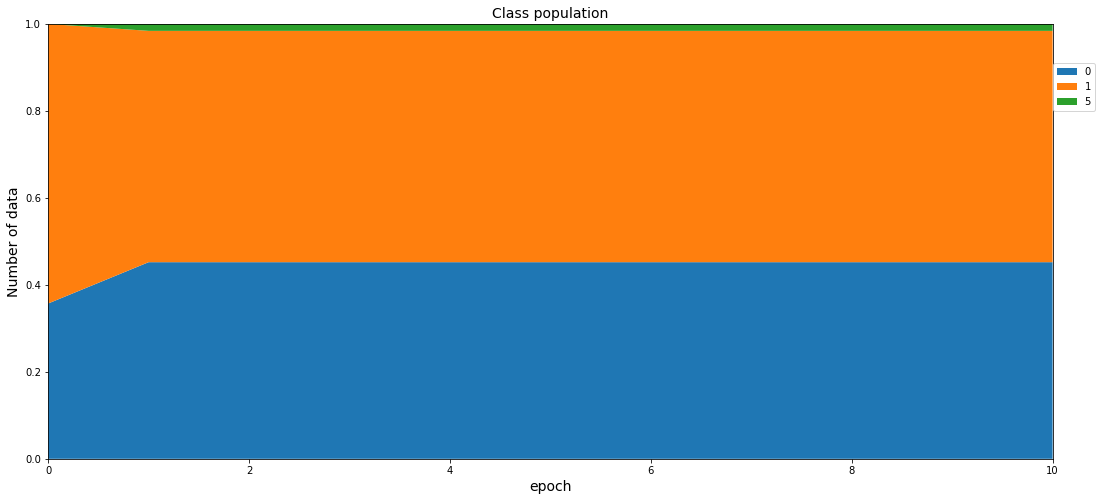

In [3]:
outlier_ind = 5
pre_data_config = {0:500,1:900}
obs_plan = 10*[{0:170,1:200,outlier_ind:6}]#+10*[{0:170,1:200,outlier_ind:5,6:7}]+10*[{0:170,1:200,outlier_ind:4,7:20,8:100}]

plan_tot = [pre_data_config]+obs_plan
population_by_group = ah.plot_population(plan_tot)

In [4]:
ntry = 2
n_night = 10
n_questions = 0.5 # can be an integer or an array of numbers np.random.randint(3,7,n_night)
prefix = 'test1'

epochs = 5
noise = 0.1
check_c = True
nightly=False
givey = True
nmin_pre=None
save_latent = False

aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.04,
    height_shift_range=0.04,
#     brightness_range=0.01,
#        shear_range=0.0,
    zoom_range=0.04,
#     horizontal_flip=True,
#     vertical_flip=True,
    fill_mode="nearest")


In [5]:
nmin,outlier_ind0,pre_data_config0,obs_plan0 = ah.planmaker(path,nmin_pre=nmin_pre,outlier_ind=outlier_ind)
n_questions0 = int(0.7*nmin)

if n_questions is None: n_questions=n_questions0
if outlier_ind is None: outlier_ind=outlier_ind0
if pre_data_config is None: pre_data_config=pre_data_config0
if obs_plan is None: obs_plan=obs_plan0
print(pre_data_config)
print(obs_plan[0])

if type(n_questions) is int or type(n_questions) is float:
    if n_questions==1 and type(n_questions) is float:
        assert 0,'Warning, when you choose 1, it should be integer.'
    n_questions = n_night*[n_questions]

if x.ndim==3:
    n_tot,lx,ly = x.shape
#     x = x.reshape(n_tot,lx*ly)
    x = x[:,:,:,None]
    nch = 1
elif x.ndim==4:
    n_tot,lx,ly,nch = x.shape

if noise!=0:
    x += np.random.normal(0,noise,x.shape)
n_class,class_labels, nums = ah.describe_labels(y,verbose=0)

# data 0
x, y, x_pre, y_pre = ah.data_prepare(x,y,pre_data_config)
# ah.describe_labels(y_pre,verbose=1)

# observation
obs = ah.Observetory(obs_plan,x,y)

y = y_pre if givey else None
    
ahunt = ah.AHunt(x_pre, y=y, interest=None, aug=aug)
ahunt.fit()  
    
ahunt0 = ah.AHunt(x_pre, y=y, interest=None, aug=aug)
ahunt0.fit()

if n_night is None: n_night = obs.n_plan

for night in range(n_night):
    x_obs,y_obs = obs.new_obs(safemode=1,nightly=nightly)

if n_night is None: n_night = obs.n_plan

outlier is  class5
{0: 500, 1: 900}
{0: 170, 1: 200, 5: 6}


In [7]:
res_all = []

for nt in range(ntry):
    res1 = []
    res2 = []
    res3 = []
    res4 = []
    # if save_latent:
    z_mus = []
    lbls = []

    phc = ah.PredictionHistoryChecker()

    for night in range(n_night):
        print('try:{}, night:{}'.format(nt,night),end='\r')
        x_obs,y_obs = obs.new_obs(safemode=1,nightly=nightly)
    #     describe_labels(y_obs,verbose=1)

        out_obs = y_obs==outlier_ind
        y_true = out_obs.astype(int)
        n_anomaly = np.sum(out_obs)
        ano_inds = np.argwhere(out_obs)[:,0]

        # Method 1
        scr_ano = ah.iforest_get_anomalies(x_obs.reshape(-1,lx*ly*nch))
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh

        rws = ah.rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)
        inds,true_guess = ah.get_tguess(n_questions[night],scr_ano,ano_inds)
        res1.append([rws,rc,pr,mcc,true_guess])

        # Method 2
        z_mu = ahunt0.to_latent(x_obs)
        scr_ano = ah.iforest_get_anomalies(z_mu)
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh
        rws = ah.rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)
        inds,true_guess = ah.get_tguess(n_questions[night],scr_ano,ano_inds)
        res2.append([rws,rc,pr,mcc,true_guess])

        # Method 3
        z_mu = ahunt.to_latent(x_obs)
        if save_latent:
            z_mus.append(z_mu)
            lbls.append(y_obs)
        scr_ano = ah.iforest_get_anomalies(z_mu)
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh
        rws = ah.rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)

        true_guess = phc.get_tguess(n_questions[night],scr_ano,ano_inds,x_obs)
        res3.append([rws,rc,pr,mcc,true_guess])

        # Method 4
        true_guess = ahunt.human_call(x_obs,y_obs,n_questions[night])

        ahunt.fit()
    #     model_par.append(stds_model(ahunt.clf))
        scr_ano = ahunt.predict(x_obs)
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh
        rws = ah.rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)
        res4.append([rws,rc,pr,mcc,true_guess])

    res1 = np.array(res1)
    res2 = np.array(res2)
    res3 = np.array(res3)
    res4 = np.array(res4)

    res_all.append([res1,res2,res3,res4])
    
#     if check_c and not nightly
#         x_obs,y_obs
    
    
np.save('{}{}_res'.format(prefix,fname),res_all)

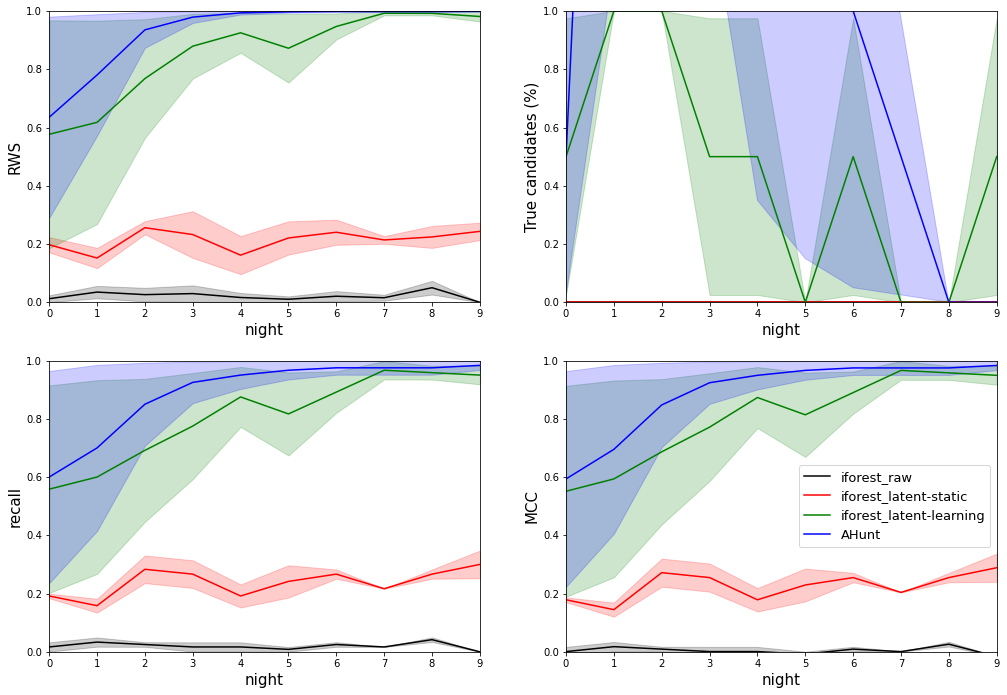

In [11]:
res_all = np.load('{}{}_res.npy'.format(prefix,fname))
# metrics_all = np.array([i[:-2] for i in res_all])

alpha = 0.2
fig,axs = plt.subplots(2,2,figsize=(14,10))

lbls = 'iforest_raw','iforest_latent-static','iforest_latent-learning','AHunt'
clrs = ['k','r','g','b']
metric_names = ['RWS','True candidates (%)','recall','MCC']


for j,jj in enumerate([0,4,1,3]):
    ax = axs[j//2,j%2]
    for  i in range(4):
        ah.analyze_plot(ax, metric=res_all[:,i,:,jj], clr=clrs[i], label=lbls[i], alpha=alpha)
        ax.set_xlabel('night',fontsize=15)
        ax.set_ylabel(metric_names[j],fontsize=15)
        ax.set_xlim(0,res_all.shape[2]-1)
        ax.set_ylim(0,1)
ax.legend(fontsize=13)
plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=None, hspace=None)
# plt.savefig('{}result_{}.jpg'.format(prefix,fname),dpi=150)

In [28]:
fname = 'mnist'
path = '/home/vafaeisa/scratch/datasets/prepared/{}.npz'.format(fname)
x,y,int_mapper,lbl_mapper = ah.load_npz(path,verbose=1)
x = x/x.max()

pre_data_config = {0:500,1:500}
x, y, x_train, y_train = ah.data_prepare(x,y,pre_data_config)
x.shape,y.shape

(70000, 28, 28) (70000,)
labels/numbers are:
	class0   /  6903
 	class1   /  7877
 	class2   /  6990
 	class3   /  7141
 	class4   /  6824
 	class5   /  6313
 	class6   /  6876
 	class7   /  7293
 	class8   /  6825
 	class9   /  6958



((69000, 28, 28), (69000,))

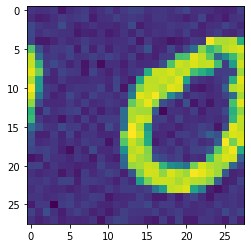

In [29]:
def changer(x):
    xc = np.roll(x,shift=np.random.choice([-1,1])*7,axis=1)
    xc += np.random.normal(0,0.05,xc.shape)

    return xc
    
inds = np.arange(x_train.shape[0])
np.random.shuffle(inds)

img = changer(x_train[inds[0]])
plt.imshow(img)

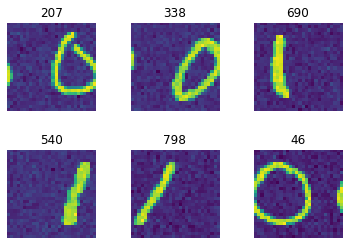

In [30]:
inds = np.arange(x_pre.shape[0])
np.random.shuffle(inds)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(6):
    ic = inds[i]
    x_train[ic] = changer(x_train[ic])
    
    ax = fig.add_subplot(2, 3, i+1)
    ax.imshow(x_train[ic])    
    ax.set_title(str(ic))
    ax.axis('off')

In [44]:



# x_train
# y_train

x_w = x_train+0
y_w = y_train+0

ndata = x_train.shape[0]

weight = np.ones(ndata)

weight[100] = 3
weight[200] = 3

wlx = []
wly = []
for i in np.argwhere(weight!=1)[:,0]:
    w = int(weight[i])
    wlx.append(w*[x_train[i]])
    wly.append(w*[y_train[i]])

wlx = np.concatenate(wlx,axis=0)
wly = np.concatenate(wly,axis=0)
x_w = np.concatenate([x_train,wlx],axis=0)
y_w = np.concatenate([y_train,wly],axis=0)
x_w.shape,y_w.shape

((1006, 28, 28), (1006,))

(6, 28, 28)

In [22]:
clf,drt = ah.build_model_2dconv(shape=(28,28,1),
                                n_class=22,
                                n_latent=64,
                                n_layers=1,
                                kernel_size=3,
                                pooling_size=2,
                                l1=1e-10)
clf.summary()

Model: "Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                2

In [ ]:
history = self.clf.fit(xx, yy,
                       batch_size=batch_size,
                       epochs=epochs,
                       validation_split=validation_split,
                       verbose=verbose)